# Project Title
### Data Engineering Capstone Project

#### Project Summary
--describe your project at a high level--

The project follows the follow steps:
* Step 1: Scope the Project and Gather Data
* Step 2: Explore and Assess the Data
* Step 3: Define the Data Model
* Step 4: Run ETL to Model the Data
* Step 5: Complete Project Write Up

In [1]:
# Do all imports and installs here
import pandas as pd
import configparser
from datetime import datetime
import os
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, col , to_date , monotonically_increasing_id , when,trim , explode , array , struct,expr,concat_ws
from pyspark.sql.functions import year, month, dayofmonth, hour, weekofyear, date_format , dayofweek,lit
from pyspark.sql.types import StructType, StructField, StringType , LongType , DoubleType , TimestampType
os.environ['PYSPARK_SUBMIT_ARGS'] = "--packages=com.amazonaws:aws-java-sdk-bundle:1.11.271,org.apache.hadoop:hadoop-aws:3.1.2 pyspark-shell"


In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.\
config("spark.jars.packages","saurfang:spark-sas7bdat:2.0.0-s_2.11")\
.config("spark.jars.packages", "org.apache.hadoop:hadoop-aws:2.7.0") \
.config("spark.jars.packages","com.amazonaws:aws-java-sdk-pom:1.10.34") \
.enableHiveSupport().getOrCreate()

### Step 1: Scope the Project and Gather Data

#### Scope 
Scope of this project is to understand what crops are sown in India , and what was the avg weather during that time period. This will help us in understanding how agriculture pattern has evolved in India based on the weather changes over the years.

#### Describe and Gather Data 
I will be using using two datasets for this project
##### 1: District-wise, season-wise crop production statistics from 1997 (https://data.gov.in/resources/district-wise-season-wise-crop-production-statistics-1997)
* This data includes crop production in India from 1997-2015
* This Includes what was the crops produced in a particular state. And its production quantity(Tonnes) and area(Hectare) 

##### 2: World Temperature Data (https://www.kaggle.com/berkeleyearth/climate-change-earth-surface-temperature-data)
* This data includes temperature data from 1743 - 2013
* The world temperature dataset has multiple datasets under it , for the purpose of this project i will be using GlobalLandTemperaturesByState.csv dataset . As this perticular dataset is consist weather for a state in a perticular country on a perticular day.

#### Information about the datasets
* Both the datasets are of type csv.
* Combined together both the datasets consists of over 891766 rows.
* World tempertature data will be filtered based on multiple conditions such as country as India and min and maximum years as per the crop production data.

In [3]:
# Read in the data here
world_crop_produce_data = spark.read.option('header',True).csv('./data/worldwide-crop-production/original/*')
world_temp_data = spark.read.option('header',True).csv('./data/world_temperature_data/GlobalLandTemperaturesByCountry.csv')

## Reusable udf's

In [4]:
#Trim spaces of strings
trim_str_udf = udf(lambda x : str(x.strip()))

#Parse string to int
str_to_int_udf = udf(lambda x: int(x))

#Extract year(int) from datetime string y-m-d
extract_year_udf = udf(lambda x: datetime.strptime(x, '%Y-%m-%d').year)

#Convert trim & string to lower case
str_to_lower_udf = udf(lambda x: x.lower())


## Transpose world-crop-produce year columns to rows

In [29]:
world_crop_produce=world_crop_produce_data.select('Area','Area Code','Item','Item Code','Element','Element Code','Unit','Y1961','Y1962','Y1963','Y1964',
'Y1965','Y1966','Y1967','Y1968','Y1969','Y1970','Y1971','Y1972','Y1973','Y1974','Y1975','Y1976','Y1977',
'Y1978','Y1979','Y1980','Y1981','Y1982','Y1983','Y1984','Y1985','Y1986','Y1987','Y1988','Y1989','Y1990','Y1991',
'Y1992','Y1993','Y1994','Y1995','Y1996','Y1997','Y1998','Y1999','Y2000','Y2001','Y2002','Y2003','Y2004',
'Y2005','Y2006','Y2007','Y2008','Y2009','Y2010','Y2011','Y2012','Y2013','Y2014')

def to_explode(df, by):

    # Filter dtypes and split into column names and type description
    cols, dtypes = zip(*((c, t) for (c, t) in df.dtypes if c not in by))
    # Spark SQL supports only homogeneous columns
    assert len(set(dtypes)) == 1, "All columns have to be of the same type"

    # Create and explode an array of (column_name, column_value) structs
    kvs = explode(array([
      struct(lit(c).alias("year"), col(c).alias("qty")) for c in cols
    ])).alias("kvs")

    return df.select(by + [kvs]).select(by + ["kvs.year", "kvs.qty"])

world_crop_produce = to_explode(world_crop_produce, ['Area','Area Code','Item','Item Code','Element','Element Code','Unit'])
world_crop_produce = world_crop_produce.withColumn('year',world_crop_produce.year.substr(2,4))
world_crop_produce.show(5)


+-----------+---------+-------------------+---------+--------------+------------+----+----+----+
|       Area|Area Code|               Item|Item Code|       Element|Element Code|Unit|year| qty|
+-----------+---------+-------------------+---------+--------------+------------+----+----+----+
|Afghanistan|        2|Almonds, with shell|      221|Area harvested|        5312|  ha|1961|null|
|Afghanistan|        2|Almonds, with shell|      221|Area harvested|        5312|  ha|1962|null|
|Afghanistan|        2|Almonds, with shell|      221|Area harvested|        5312|  ha|1963|null|
|Afghanistan|        2|Almonds, with shell|      221|Area harvested|        5312|  ha|1964|null|
|Afghanistan|        2|Almonds, with shell|      221|Area harvested|        5312|  ha|1965|null|
+-----------+---------+-------------------+---------+--------------+------------+----+----+----+
only showing top 5 rows



# Step 2: Explore and Assess the Data


In [28]:
world_temp_data.printSchema()
world_temp_data.count()
world_temp_data.show(5)

root
 |-- dt: string (nullable = true)
 |-- AverageTemperature: string (nullable = true)
 |-- AverageTemperatureUncertainty: string (nullable = true)
 |-- Country: string (nullable = true)

+----------+------------------+-----------------------------+-------+
|        dt|AverageTemperature|AverageTemperatureUncertainty|Country|
+----------+------------------+-----------------------------+-------+
|1743-11-01|4.3839999999999995|                        2.294|  Åland|
|1743-12-01|              null|                         null|  Åland|
|1744-01-01|              null|                         null|  Åland|
|1744-02-01|              null|                         null|  Åland|
|1744-03-01|              null|                         null|  Åland|
+----------+------------------+-----------------------------+-------+
only showing top 5 rows



In [10]:
world_crop_produce.printSchema()
world_crop_produce.count()

root
 |-- Area: string (nullable = true)
 |-- Area Code: string (nullable = true)
 |-- Item: string (nullable = true)
 |-- Item Code: string (nullable = true)
 |-- Element: string (nullable = true)
 |-- Element Code: string (nullable = true)
 |-- Unit: string (nullable = true)
 |-- year: string (nullable = false)
 |-- qty: string (nullable = true)



2255094

## Filter temperature data based on crop years

### Extract minimum and maximum year in the agriculture data to filter temperature data

In [11]:

crop_produce_years = world_crop_produce.select('year').distinct()
crop_produce_years = crop_produce_years.withColumn('year',str_to_int_udf(crop_produce_years.year))
min_crop_produce_year = int(crop_produce_years.agg({'year':'min'}).collect()[0][0])
max_crop_produce_year = int(crop_produce_years.agg({'year':'max'}).collect()[0][0])
print(min_crop_produce_year,max_crop_produce_year)

1961 2014


### Filter temperature data based on the minimun and maximun year of agriculture data

In [12]:
world_temperature_data = world_temp_data.withColumn('year',extract_year_udf(world_temp_data.dt))
world_temperature_data = world_temperature_data.filter((col('year') >= min_crop_produce_year) & (col('year') <= max_crop_produce_year))
world_temperature_data.count()

153819

### Step 2: Explore and Assess the Data
#### Explore the Data 
Identify data quality issues, like missing values, duplicate data, etc.

#### Cleaning Steps
Document steps necessary to clean the data

#### Initial crop data counts

In [17]:
world_crop_produce.count()

2255094

* Filter crop produce data where quantity isnot null
* Drop Duplicates from crop data

In [15]:
world_crop_produce = world_crop_produce.where(world_crop_produce.qty.isNotNull())
world_crop_produce = world_crop_produce.dropDuplicates()
world_crop_produce.count()

1725544

### Initial temperature data count

In [18]:
world_temperature_data.count()

153819

In [19]:
world_temperature_data = world_temperature_data.filter(world_temperature_data.AverageTemperature.isNotNull())
world_temperature_data.count()

152965

### Step 3: Define the Data Model
#### 3.1 Conceptual Data Model
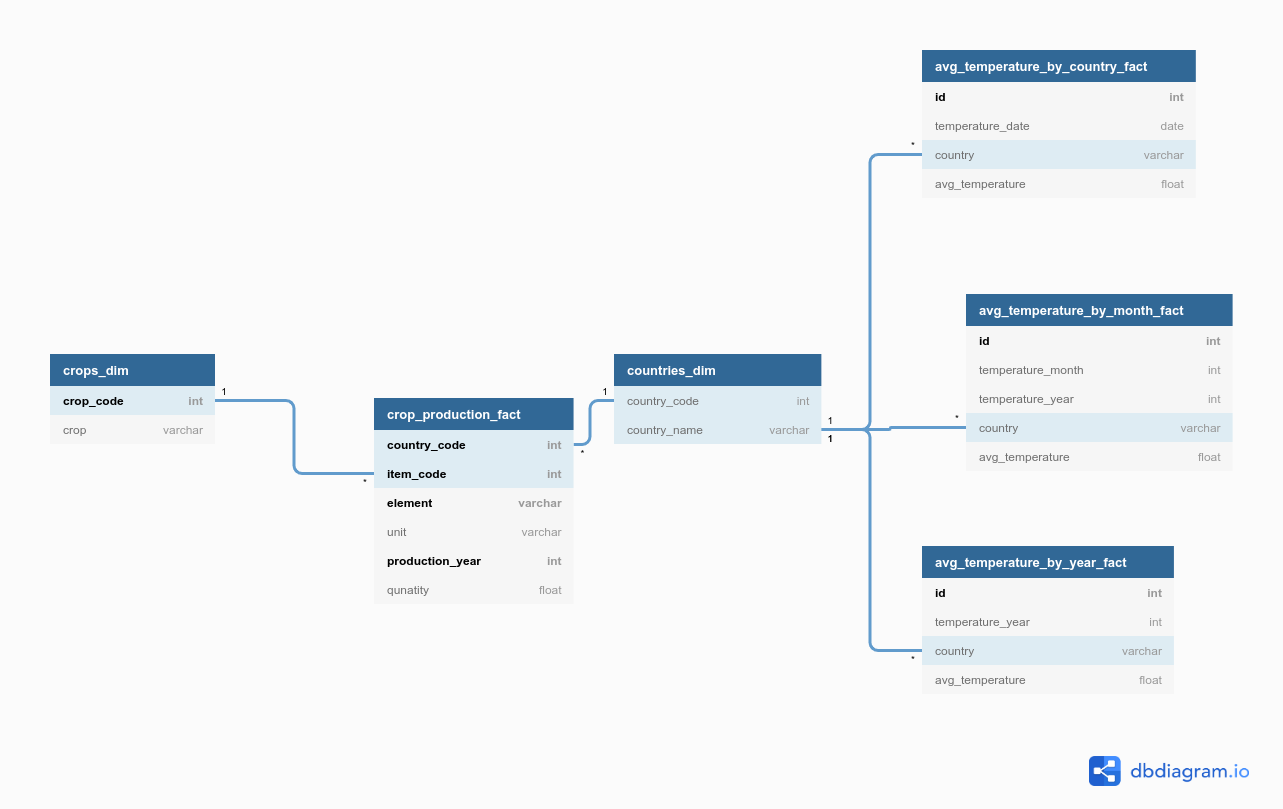

* <b>crop_production_fact</b> : This table consist of all the crops produced , harvested etc in a particular country in a particular year.
* <b>crops_dim</b> : crops_dim table has unique crop_codes and crops . crop_code will be referenced in crop_production_fact using a one-to-many relationship.
* <b>countries_dim</b> : This table consists of countries and country codes . This table will be populated using combination on temperature data and crop produce data. Since some of the data wont match in the datasets , we might find that some of the country codes will be null. country_code will be referenced in crop_production_fact table using a one-to-many relationship.
* <b>avg_temperature_by_country_fact</b> : This table will have actual average temperature data in particular country on a perticular date.
* <b>avg_temperature_by_month_fact</b> : This table will be populated by generating average temperature for months using data from avg_temperature_by_country_fact.
* <b>avg_temperature_by_year_fact</b> : This table will be populated by generating average temperature for years using data from avg_temperature_by_country_fact.

Choosing this particular data model as i will be able to do temperature to crop analysis at daily / monthly and yearly basis. Combining countries will allow me to join crops and temerature data.

#### 3.2 Mapping Out Data Pipelines
* Create crop_productions_fact data by select / renaming necessary columns from world crop produce data.
* Calulate average monthly / yearly temperature data from world temperature data.
* Generate unique crop and crop codes from world_crop_produce data.
* Generate unique countries data from world_crop_produce.
* Generate unique countries data from world_temperature_data.
* Combine countries from temperature and crop produce data.


### Step 4: Run Pipelines to Model the Data 
#### 4.1 Create the data model
Build the data pipelines to create the data model.

## Get list of items as crops from crops data

In [26]:
crops = world_crop_produce.select('Item' , 'Item Code').distinct()
crops = crops.withColumnRenamed('Item','crop').withColumnRenamed('Item Code','crop_code')
crops.show(5)

+--------------------+---------+
|                crop|crop_code|
+--------------------+---------+
|  Flax fibre and tow|      773|
|      Safflower seed|      280|
| Lettuce and chicory|      372|
|            Soybeans|      236|
|Grapefruit (inc. ...|      507|
+--------------------+---------+
only showing top 5 rows



## Get list of countries from agriculture data

In [24]:
countries = world_crop_produce.select('Area' , 'Area Code').distinct()
countries = countries.withColumnRenamed('Area','country').withColumnRenamed('Area Code','country_code')

countries = countries.withColumn('country',str_to_lower_udf(countries.country))
countries.show(5)

+--------------------+------------+
|             country|country_code|
+--------------------+------------+
|saint kitts and n...|         188|
|             romania|         183|
|     china, mainland|          41|
|            suriname|         207|
|               yemen|         249|
+--------------------+------------+
only showing top 5 rows



## Get countries from temperature data

In [25]:
temp_countries = world_temperature_data.selectExpr('Country as country').distinct()
temp_countries = temp_countries.withColumn('country',str_to_lower_udf(temp_countries.country))
temp_countries.show(5)

+------------+
|     country|
+------------+
|        chad|
|    anguilla|
|kingman reef|
|    paraguay|
|      russia|
+------------+
only showing top 5 rows



## Match countries in crop and temperature data

In [27]:
common_countries = temp_countries.join(countries, on=['country'],how='left')
common_countries.show(5)

+------------+------------+
|     country|country_code|
+------------+------------+
|        chad|          39|
|    anguilla|        null|
|kingman reef|        null|
|    paraguay|         169|
|      russia|        null|
+------------+------------+
only showing top 5 rows



#### 4.2 Data Quality Checks
Explain the data quality checks you'll perform to ensure the pipeline ran as expected. These could include:
 * Integrity constraints on the relational database (e.g., unique key, data type, etc.)
 * Unit tests for the scripts to ensure they are doing the right thing
 * Source/Count checks to ensure completeness
 
Run Quality Checks

In [ ]:
# Perform quality checks here

#### 4.3 Data dictionary 
Create a data dictionary for your data model. For each field, provide a brief description of what the data is and where it came from. You can include the data dictionary in the notebook or in a separate file.

#### Step 5: Complete Project Write Up
* Clearly state the rationale for the choice of tools and technologies for the project.
* Propose how often the data should be updated and why.
* Write a description of how you would approach the problem differently under the following scenarios:
 * The data was increased by 100x.
 * The data populates a dashboard that must be updated on a daily basis by 7am every day.
 * The database needed to be accessed by 100+ people.